# Convolutional AutoEncoder with MNIST

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [3]:
# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load MNIST Data

In [4]:
batch_size = 128
test_batch_size = 5

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/',
                            train=True,
                            transform=transform,
                            download=True)

test_data  = datasets.MNIST(root='~/.pytorch/MNIST_data/',
                            train=False,
                            transform=transform,
                            download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader  = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=test_batch_size,
                                           shuffle=False)

len(train_data)

60000

## Define Model

In [6]:
# N:input, F:filter, S:stride, P:padding

def c_conv(N, F, S=1, P=0):
    return int((N+2*P-F)/S+1)

def c_pool(N, F):
    return int(N/F)

# Transposed convolution
def t_conv(N, F, S=1, P=0):
    return int(S*(N-1)+F-2*P)

In [7]:
# Encoder
e0 = 28
e1 = c_conv(e0, 5)

e2 = c_conv(e1, 5)
e3 = c_pool(e2, 2)

e4 = c_conv(e3, 5)
e5 = c_pool(e4, 2)

print(e0, e1, e2, e3, e4, e5)

# Decoder - no pooling layer
d0 = e5
d1 = t_conv(d0, 5, 2, 1)
d2 = t_conv(d1, 4, 2, 1)
d3 = t_conv(d2, 4, 2, 1)

print(d0, d1, d2, d3)

28 24 20 10 6 3
3 7 14 28


In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),            
            
            nn.Conv2d(16, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)     # 64*3*3
        )
        
    def forward(self, x):
        z = self.encoder(x)
        
        return z

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 5, stride=2, padding=1),    # 64*3*3
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.decoder(z)
        out = out.view(-1,1,28,28)
        
        return out

In [10]:
E = Encoder().to(device)
D = Decoder().to(device)

loss = nn.MSELoss()

# Encoder + Decoder 함께 학습
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.0002)

## Training

In [11]:
num_epochs = 40

for epoch in range(num_epochs):
    
    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        x = batch_images.to(device)   # no flatten
        
        pred = D(E(x))          # E --> D
        cost = loss(pred, x)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.5f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))
            
    if (epoch + 1) % 20 == 0:
        # Save model
        torch.save(E.state_dict(), 'saved_models/ConvAE_mnist_E_{:03d}.pkl'.format(epoch+1))
        torch.save(D.state_dict(), 'saved_models/ConvAE_mnist_D_{:03d}.pkl'.format(epoch+1))

Epoch [1/40], lter [468/468] Loss: 0.12844
Epoch [2/40], lter [468/468] Loss: 0.05853
Epoch [3/40], lter [468/468] Loss: 0.04664
Epoch [4/40], lter [468/468] Loss: 0.03652
Epoch [5/40], lter [468/468] Loss: 0.03162
Epoch [6/40], lter [468/468] Loss: 0.02837
Epoch [7/40], lter [468/468] Loss: 0.02483
Epoch [8/40], lter [468/468] Loss: 0.02272
Epoch [9/40], lter [468/468] Loss: 0.02067
Epoch [10/40], lter [468/468] Loss: 0.02121
Epoch [11/40], lter [468/468] Loss: 0.02100
Epoch [12/40], lter [468/468] Loss: 0.02031
Epoch [13/40], lter [468/468] Loss: 0.01802
Epoch [14/40], lter [468/468] Loss: 0.01775
Epoch [15/40], lter [468/468] Loss: 0.01637
Epoch [16/40], lter [468/468] Loss: 0.01634
Epoch [17/40], lter [468/468] Loss: 0.01717
Epoch [18/40], lter [468/468] Loss: 0.01571
Epoch [19/40], lter [468/468] Loss: 0.01480
Epoch [20/40], lter [468/468] Loss: 0.01384
Epoch [21/40], lter [468/468] Loss: 0.01506
Epoch [22/40], lter [468/468] Loss: 0.01364
Epoch [23/40], lter [468/468] Loss: 0.013

In [12]:
# Load weights of model
# E.load_state_dict(torch.load('saved_models/ConvAE_mnist_E_040.pkl'))
# D.load_state_dict(torch.load('saved_models/ConvAE_mnist_D_040.pkl'))

## Generate images

In [13]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

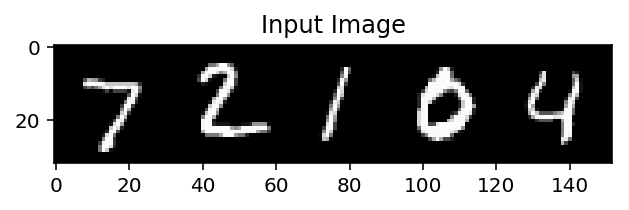

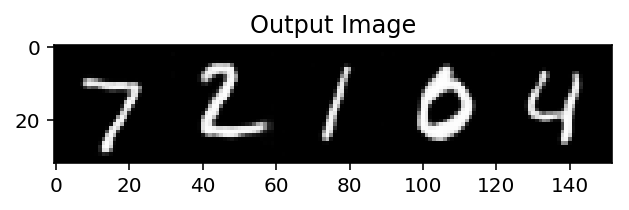

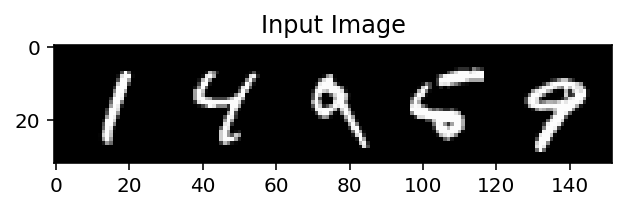

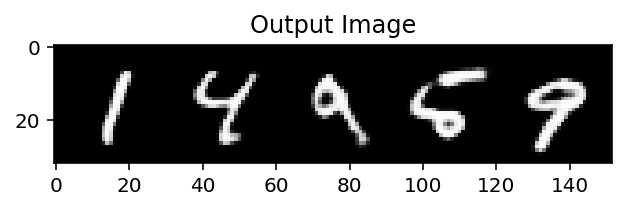

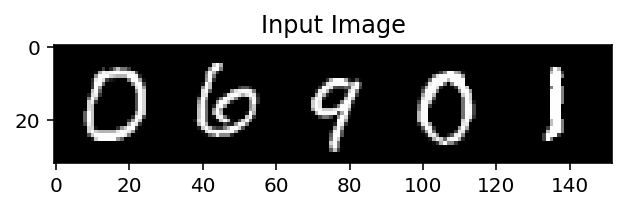

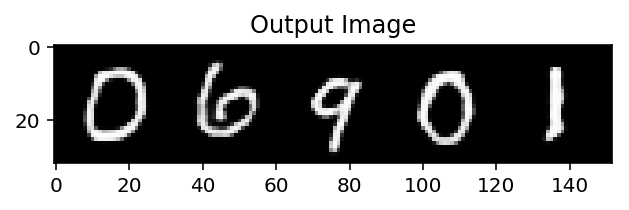

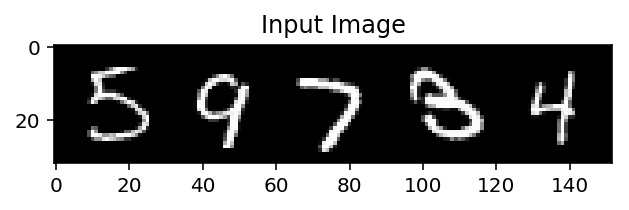

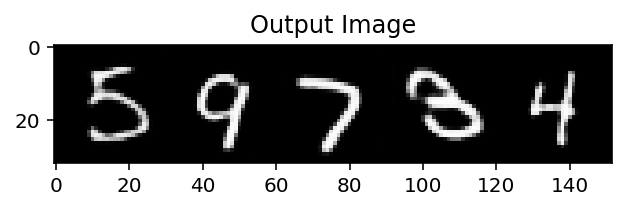

In [14]:
E.eval()
D.eval()

for i, (images, labels) in enumerate(test_loader):
    
    imshow(utils.make_grid(images, normalize=True), "Input Image")
    images  = images.view(test_batch_size, 1, 28, 28).to(device)
    
    outputs = D(E(images))
    outputs = outputs.view(test_batch_size, 1, 28, 28)
    
    imshow(utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    print('=========================================')
    
    if i > 2 : break